First of all, set environment variables and initialize spark context:

In [1]:
%env SPARK_DRIVER_MEMORY=8g

from zoo.common.nncontext import *
sc = init_nncontext(init_spark_conf().setMaster("local[4]"))

env: SPARK_DRIVER_MEMORY=8g


# Understanding recurrent neural networks

----

In this section we will build recurrent neural networks to finish the same task as we did in chapter 3.

## A first recurrent layer in Keras API of Analytics Zoo

The process we just naively implemented in Numpy corresponds to an actual layer: the `SimpleRNN` layer:

In [2]:
from zoo.pipeline.api.keras.layers import SimpleRNN

There is just one minor difference: `SimpleRNN` processes batches of sequences, like all other Keras API of Analytics Zoo layers, not just a single sequence like 
in our Numpy example. This means that it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps, 
input_features)`.

Like all recurrent layers in Keras API of Analytics Zoo, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive 
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each 
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor 
argument. Let's take a look at an example:

In [3]:
from zoo.pipeline.api.keras.models import Sequential
from zoo.pipeline.api.keras.layers import Embedding, SimpleRNN

Following is the preprocessing method. You do not need to care about the detail of its implementation. Basically this `pad_sequences` method fix all the sequences to a same length.

In [4]:
def pad_sequences(sequences, maxlen=None, dtype='int32',
                  padding='pre', truncating='pre', value=0.):    
    lengths = [len(s) for s in sequences]

    nb_samples = len(sequences)
    if maxlen is None:
        maxlen = np.max(lengths)

    # take the sample shape from the first non empty sequence
    # checking for consistency in the main loop below.
    sample_shape = tuple()
    for s in sequences:
        if len(s) > 0:
            sample_shape = np.asarray(s).shape[1:]
            break

    x = (np.ones((nb_samples, maxlen) + sample_shape) * value).astype(dtype)
    for idx, s in enumerate(sequences):
        if not len(s):
            continue  # empty list/array was found
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        else:
            raise ValueError('Truncating type "%s" not understood' % truncating)

        # check `trunc` has expected shape
        trunc = np.asarray(trunc, dtype=dtype)
        if trunc.shape[1:] != sample_shape:
            raise ValueError('Shape of sample %s of sequence at position %s is different from expected shape %s' %
                             (trunc.shape[1:], idx, sample_shape))

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
    return x

Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data. 

In [5]:
from zoo.pipeline.api.keras.datasets import imdb

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

(input_train, y_train), (input_test, y_test) = imdb.load_data(nb_words=max_features)
input_train = pad_sequences(input_train, maxlen=maxlen)
input_test = pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

input_train shape: (25000, 500)
input_test shape: (25000, 500)


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

#### Specify input shape
_One could add an embedding layer as our first layer in Keras as following:_
    
    model = Sequential()
    model.add(Embedding(10000, 32))
_In Keras API of Analytics Zoo, you need to specify the input shape of first layer, in this example, the sequence length is 500, as is shown above, so we could build our model as following:_

In [6]:
model = Sequential()
model.add(Embedding(10000, 32, input_shape=(500,)))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

creating: createZooKerasSequential
creating: createZooKerasEmbedding
creating: createZooKerasSimpleRNN
creating: createZooKerasSimpleRNN
creating: createZooKerasSimpleRNN
creating: createZooKerasSimpleRNN


Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [7]:
from zoo.pipeline.api.keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32, input_shape=(500,)))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

import time
dir_name = '6-2 ' + str(time.ctime())
model.set_tensorboard('./', dir_name)
model.fit(input_train, y_train,
          nb_epoch=10,
          batch_size=128,
          validation_split=0.2)

creating: createZooKerasSequential
creating: createZooKerasEmbedding
creating: createZooKerasSimpleRNN
creating: createZooKerasDense
creating: createRMSprop
creating: createZooKerasBinaryCrossEntropy
creating: createZooKerasBinaryAccuracy


_INFO - Trained 128 records in 0.046239497 seconds. Throughput is 2768.1963 records/second. Loss is 0.16970885.

Top1Accuracy is Accuracy(correct: 4167, count: 5000, accuracy: 0.8334)_

Let's display the training and validation loss:

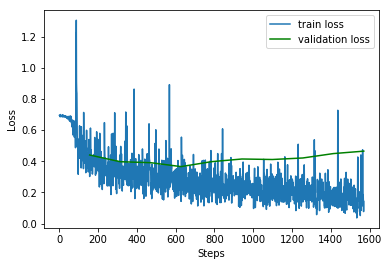

In [9]:
train_loss = np.array(model.get_train_summary('Loss'))
val_loss = np.array(model.get_validation_summary('Loss'))

import matplotlib.pyplot as plt
plt.plot(train_loss[:,0],train_loss[:,1],label='train loss')
plt.plot(val_loss[:,0],val_loss[:,1],label='validation loss',color='green')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

As a reminder, in chapter 3, our very first naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small 
recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is 
that our inputs only consider the first 500 words rather the full sequences -- 
hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some 
more advanced layers.

## A concrete LSTM example in Keras API of Analytics Zoo

Now let's switch to more practical concerns: we will set up a model using a LSTM layer and train it on the IMDB data. Here's the network, 
similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every 
other argument (there are lots) to the Keras API of Analytics Zoo defaults, which has good defaults, and things will almost always "just work" without you 
having to spend time tuning parameters by hand.

In [10]:
from zoo.pipeline.api.keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32, input_shape=(500,)))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

dir_name = '6-2 ' + str(time.ctime())
model.set_tensorboard('./', dir_name)
model.fit(input_train, y_train,
          nb_epoch=10,
          batch_size=128,
          validation_split=0.2)

creating: createZooKerasSequential
creating: createZooKerasEmbedding
creating: createZooKerasLSTM
creating: createZooKerasDense
creating: createRMSprop
creating: createZooKerasBinaryCrossEntropy
creating: createZooKerasBinaryAccuracy


_INFO - Trained 128 records in 0.335889472 seconds. Throughput is 381.07776 records/second. Loss is 0.14791179.

Top1Accuracy is Accuracy(correct: 4358, count: 5000, accuracy: 0.8716)_

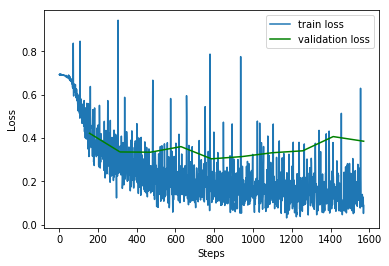

In [11]:
train_loss = np.array(model.get_train_summary('Loss'))
val_loss = np.array(model.get_validation_summary('Loss'))

plt.plot(train_loss[:,0],train_loss[:,1],label='train loss')
plt.plot(val_loss[:,0],val_loss[:,1],label='validation loss',color='green')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()